In [1]:
import os
import json
from uncertainties import ufloat, umath
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 14})

from functions import Qf2σ, prettifySample

5
dg_q0refl.json 119 119
dg_q0refl.json 118 118
dg_q0refl.json 119 119
dg_q0refl.json 119 119
5
dg_lorentz.json 119 119
dg_lorentz.json 118 118
dg_lorentz.json 119 119
dg_lorentz.json 119 119
5
dg_naive.json 119 119
dg_naive.json 118 118
dg_naive.json 119 119
dg_naive.json 119 119


<ipython-input-15-5c83a865de89>:75: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


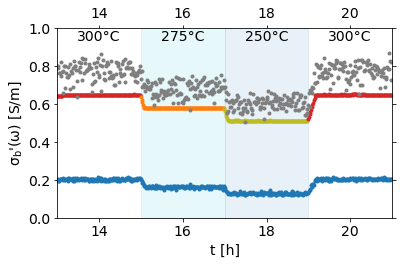

In [15]:
sids = ["dg_q0refl.json", "dg_lorentz.json", "dg_naive.json"]
colors = {
    "dg_q0refl.json": ["C3","C1","C8","C3"],
    "dg_lorentz.json": ["C0", "C0", "C0", "C0"],
    "dg_naive.json": ["C7", "C7", "C7", "C7"]
}

fig = plt.figure(figsize=(6,3.5))
grid = plt.GridSpec(1, 100, wspace=0.1, hspace=0.1, figure=fig)
ax = []
ax.append(plt.subplot(grid[0:1, :]))

ai = 0
for sid in sids:
    with open(os.path.join("..", "data", "ex_qftrace", sid), "r") as infile:
        dg = json.load(infile)
    with open(os.path.join("..", "data", "ex_qftrace", "params.json"), "r") as infile:
        params = json.load(infile)
    
    mcptdata = [i for i in dg if i["input"]["datagram"] == "qftrace"]
    print(len(mcptdata))
    A = params["mcpt"]["A"]
    B = params["mcpt"]["B"]
    C = params["mcpt"]["C"]
    ffac = 1 / params["mcpt"]["rp_nm"]
    c_i = params["cavity"]["i"]
    s_i = params["sample"]["i"]
    Vs = np.pi * ufloat(*params["sample"]["r"])**2 * ufloat(*params["sample"]["h"])
    Vc = np.pi * ufloat(*params["cavity"]["r"])**2 * ufloat(*params["cavity"]["h"])
    delta = (ufloat(*params["sample"]["m"]) / ufloat(*params["sample"]["rho"])) * (1 / Vs)

    timestamps = []
    for section in mcptdata:
        if params["reference"] in section["input"]["export"]:
            Q_c = ufloat(np.average([p["Q0"][c_i] for p in section["results"][-10:-1]]), 
                         np.std([p["Q0"][c_i] for p in section["results"][-10:-1]]))
            f_c = ufloat(np.average([p["f0"][c_i] for p in section["results"][-10:-1]]), 
                         np.std([p["f0"][c_i] for p in section["results"][-10:-1]]))
        for p in section["results"]:
            timestamps.append(p["uts"])
    t0 = min(timestamps)
    Q0c = ufloat(*params["cavity"]["Q"]["TM020"])
    f0c = f_c * ffac
    Qfac = ufloat(*params["cavity"]["Q"]["TM020"])/Q_c
    ffac = ufloat(1 / params["mcpt"]["rp_nm"], 0)

    for section in mcptdata[1:]:
        t = []
        s = []
        for p in section["results"]:
            f0 = p["f0"][c_i] * ffac
            Q0 = p["Q0"][c_i] * Qfac
            fs = p["f0"][s_i]
            Qs = p["Q0"][s_i]
            t.append((p["uts"] - t0)/3600)
            s.append(Qf2σ(Qs, Q0, fs, f0, Vs, Vc, A = A, B = B, C = C, delta = delta)["σ"].n)
        print(sid, len(t), len(s))
        ax[ai].plot(t, s, marker=".", linestyle=" ", color=colors[sid].pop(0))
    ax[ai].tick_params(left=True, right=True, top=True, bottom=True)
    ax[ai].tick_params(labelleft=True, labelright=False, labeltop=False, labelbottom=True)
    ax[ai].set_xlim(left=13, right=21)
ax[0].set_ylim(bottom=0, top=1)

ax[0].tick_params(labeltop=True)
ax[0].tick_params(labelbottom=True)

ax[0].set_ylabel("σ$_\mathrm{b}$'(ω) [S/m]")
ax[0].set_xlabel("t [h]")
ax[0].fill_between([15,17],[1,1], color="C9", alpha=0.1, zorder=0)
ax[0].fill_between([17,19],[1,1], color="C0", alpha=0.1, zorder=0)
ax[0].text(14,0.99,"300°C", ha="center", va="top")
ax[0].text(16,0.99,"275°C", ha="center", va="top")
ax[0].text(18,0.99,"250°C", ha="center", va="top")
ax[0].text(20,0.99,"300°C", ha="center", va="top")
fig.show()

fig.savefig(os.path.join("..", "outputs", "sig_qftrace.pdf"), dpi=300, format="pdf", pad_inches=0.1, bbox_inches="tight")